In [1]:
import pandas as pd
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras_tuner as kt

import tensorflow as tf
from sqlalchemy import create_engine


from sklearn.datasets import make_blobs, make_moons, make_circles
%matplotlib inline

# Importing data
Two available options below
1. Can connect to the database that has the table raw_daily_covid_info or 
2. Import directly from CSV.

Uncomment the block that you want to use

In [4]:
#Option 1 - Read from DB
#Update config.py file with password, DB name, and server
from config import db_password, db_name, db_server
db_string = f"postgresql://postgres:{db_password}@{db_server}/{db_name}"
engine = create_engine(db_string)
with engine.connect() as connection:
    covid_df = pd.read_sql("select extract(month from submission_date) as period_begin_month,extract(year from submission_date) as period_begin_year,concat(extract(month from submission_date),'-',extract(year from submission_date)) as period_begin_month_year,concat(extract(month from submission_date),'-',extract(year from submission_date),state) as covid_month_year_state,state,states.state_name_title_case,sum(new_case + pnew_case) as cases,sum(new_death+pnew_death) as deaths from raw_daily_covid_info INNER JOIN states ON raw_daily_covid_info.state=states.state_two_letter_abbreviation where state in ('MN', 'CA', 'FL','TX','WA') and submission_date >= '2020-01-01' and submission_date < '2022-01-01' group by state, states.state_name_title_case, period_begin_month,period_begin_year order by state, period_begin_year, period_begin_month;", db_string)
    housing_df = pd.read_sql("select * from housing_data;", db_string)


In [9]:

# #Option 2 - import from CSV
# covid_df = pd.read_csv("Resources/covid_daily_info.csv")
# covid_df.head()
# housing_df = pd.read_csv("Resources/housing_data.csv")

In [24]:
covid_df.columns

Index(['period_begin_month', 'period_begin_year', 'period_begin_month_year',
       'covid_month_year_state', 'state', 'cases', 'deaths'],
      dtype='object')

In [25]:
covid_df.dtypes

period_begin_month           int32
period_begin_year            int32
period_begin_month_year     object
covid_month_year_state      object
state                       object
cases                        int32
deaths                     float64
dtype: object

In [29]:
covid_df['period_begin_month'] = covid_df['period_begin_month'].astype('int')
covid_df['period_begin_year'] = covid_df['period_begin_year'].astype('int')

#dropped NA
covid_df = covid_df.dropna()
covid_df['cases'] = covid_df['cases'].astype('int')
covid_df['deaths'] = covid_df['deaths'].astype('int')
covid_df.head()

,period_begin_month,period_begin_year,period_begin_month_year,covid_month_year_state,state,cases,deaths
0,1,2020,1-2020,1-2020CA,CA,0,0
1,2,2020,2-2020,2-2020CA,CA,34,0
2,3,2020,3-2020,3-2020CA,CA,6898,150
3,4,2020,4-2020,4-2020CA,CA,41985,1740
4,5,2020,5-2020,5-2020CA,CA,61666,2153


In [28]:
housing_df.head()

,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,state,...,sold_above_list_yoy,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated
0,2020-03-01,2020-03-31,30,county,5,1146,False,"Franklin County, KY",None,Kentucky,...,0.179693,0.152381,-0.078388,-0.087056,0.530612,0.058390,-0.069388,"Frankfort, KY",23180.0,2022-01-09 14:29:56
1,2021-01-01,2021-01-31,30,county,5,143,False,"DeKalb County, AL",None,Alabama,...,-0.175758,0.126214,-0.035949,-0.031422,0.360000,0.181429,0.047500,"Fort Payne, AL",22840.0,2022-01-09 14:29:56
2,2020-09-01,2020-09-30,30,county,5,359,False,"Yolo County, CA",None,California,...,0.124419,0.183761,-0.043130,-0.114626,0.609756,-0.005629,0.208396,"Sacramento, CA",40900.0,2022-01-09 14:29:56
3,2020-11-01,2020-11-30,30,county,5,368,False,"Broomfield County, CO",None,Colorado,...,0.500000,0.333333,-0.166667,-0.030303,0.250000,-0.477273,-0.250000,"Denver, CO",19740.0,2022-01-09 14:29:56
4,2021-12-01,2021-12-31,30,county,5,702,False,"Nez Perce County, ID",None,Idaho,...,-0.007092,0.482759,0.158434,NaN,0.666667,0.181818,0.630952,"Lewiston, ID",30300.0,2022-01-09 14:29:56


# Splitting into test and train data

In [12]:
#Placeholder for data
X,y = make_moons(n_samples=1000, noise=0.8, random_state=1)
y = y.reshape(-1,1)
df = pd.DataFrame(X, columns = ["feature1", "feature2"])
df["target"] = y
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<AxesSubplot:xlabel='feature1', ylabel='feature2'>

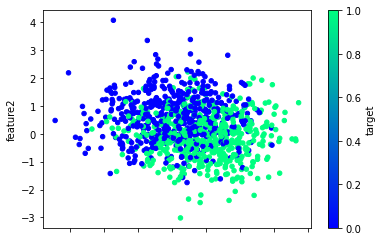

In [13]:
df.plot.scatter(x= "feature1", y="feature2", c = "target", colormap = "winter")

In [14]:
def create_model(hp):
  model = Sequential()
  activation = hp.Choice("activation", ["relu","tanh","sigmoid"])

  model.add(Dense(units = hp.Int("num_neurons", 1,8, step = 3),
                  activation  = activation,
                  input_dim = 2))
  
  for x in range(hp.Int("num_layers", 1,6)):
    model.add(Dense(units = hp.Int("num_layers_" + str(x+2), 1,10,step = 2), 
                    activation = activation 
                    ))
  model.add(Dense(units = 1, activation = "sigmoid"))

#Need to update the loss and optimizer for our problem. currently it is set to a binary classification problem
  model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

  return model
    

In [15]:
tuner = kt.Hyperband(
    create_model,
    objective = "val_accuracy",
    max_epochs = 10,
    hyperband_iterations=2,
    overwrite = True
)

In [16]:
tuner.search(X_train_scaled, y_train, epochs = 5, validation_data = (X_test_scaled, y_test))

Trial 60 Complete [00h 00m 01s]
val_accuracy: 0.699999988079071

Best val_accuracy So Far: 0.7440000176429749
Total elapsed time: 00h 01m 03s
INFO:tensorflow:Oracle triggered exit


In [17]:
tuner.get_best_hyperparameters(3)

In [18]:
tuner.get_best_hyperparameters(3)